# Evaluador de Fortaleza de Contraseñas con IA

Esta herramienta de evaluación de fortaleza de contraseñas utiliza técnicas de **Machine Learning** y **entropía** para analizar y clasificar contraseñas.

**Proyecto Académico**  
Adaptado para uso educativo en análisis de ciberseguridad y clasificación de contraseñas.

---

## Funcionalidades

✅ Clasificación automática de contraseñas (Débil, Media, Fuerte)  
✅ Cálculo de entropía Shannon y práctica  
✅ Estimación de tiempo de crackeo  
✅ Verificación contra base de datos RockYou  
✅ Visualizaciones interactivas


In [11]:
# PASO 1: Importar librerías
import pandas as pd
import sqlite3
import string
import math  
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# PASO 2: Cargar datasets

# A. https://www.kaggle.com/datasets/divanshu22/password
df_a = pd.read_csv("password_strength_1.csv", on_bad_lines='skip')
df_a = df_a[["password", "strength"]]  # Ya tiene ambas columnas

# B. https://www.kaggle.com/datasets/jeffersonvalandro/password-dataset
df_b = pd.read_csv("password_strength_2.csv")
df_b.rename(columns={"Password": "password", "Strength": "strength"}, inplace=True)
df_b = df_b[["password", "strength"]]  # Mantener solo columnas necesarias

# C. https://www.kaggle.com/datasets/soylevbeytullah/password-datas
conexion = sqlite3.connect("password_data.sqlite")
df_c = pd.read_sql("SELECT * FROM Users;", conexion)
df_c.rename(columns={"Password": "password", "Strength": "strength"}, inplace=True)
df_c = df_c[["password", "strength"]]

# Cargar RockYou en un set de contraseñas filtradas
ruta_rockyou = "rockyou.txt"

conjunto_rockyou = set()

with open(ruta_rockyou, "r", encoding="utf-8", errors="ignore") as f:
    for linea in f:
        partes = linea.strip().split(maxsplit=1)
        if len(partes) == 2:
            _, contrasena = partes
            conjunto_rockyou.add(contrasena)

def esta_en_rockyou(contrasena):
    return contrasena in conjunto_rockyou
    

# PASO 3: Combinar y limpiar datos
df_todo = pd.concat([df_a, df_b, df_c], ignore_index=True)
df_todo.dropna(inplace=True)
df_todo.drop_duplicates(subset="password", inplace=True)

def calcular_entropia(contrasena):
    if len(contrasena) == 0:
        return 0
    probs = [contrasena.count(c) / len(contrasena) for c in set(contrasena)]
    return round(-sum(p * math.log2(p) for p in probs), 2)


# PASO 4: Extracción de características
def extraer_caracteristicas(pw):
    pw = str(pw)
    return pd.Series({
        "longitud": len(pw),
        "digitos": sum(c.isdigit() for c in pw),
        "mayusculas": sum(c.isupper() for c in pw),
        "minusculas": sum(c.islower() for c in pw),
        "simbolos": sum(c in string.punctuation for c in pw),
        "espacios": int(" " in pw),
        "repeticiones": int(len(set(pw)) < len(pw)),
        "entropia": calcular_entropia(pw),
    })


# Asegurar que todas las etiquetas de fortaleza estén en formato string
df_todo["strength"] = df_todo["strength"].astype(str)
df_todo["strength"] = df_todo["strength"].str.capitalize()
clases_validas = ["Weak", "Medium", "Strong"]
df_todo = df_todo[df_todo["strength"].isin(clases_validas)]

# Extraer características del dataframe filtrado
caracteristicas = df_todo["password"].apply(extraer_caracteristicas)
X = caracteristicas
mapa_etiquetas = {"Weak": 0, "Medium": 1, "Strong": 2}
y = df_todo["strength"].map(mapa_etiquetas)


# PASO 5: División Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PASO 6: Entrenar modelo XGBoost
modelo = XGBClassifier(eval_metric="mlogloss")
modelo.fit(X_train, y_train)


# PASO 7: Evaluar
y_pred = modelo.predict(X_test)
precision = accuracy_score(y_test, y_pred)
print(f"✅ Precisión en Test: {precision * 100:.2f}%")


# PASO 8: Validación cruzada
puntajes_cv = cross_val_score(modelo, X, y, cv=5, scoring='accuracy')
print("🔁 Puntajes de Validación Cruzada:", puntajes_cv)
print(f"📊 Precisión Media CV: {puntajes_cv.mean() * 100:.2f}%")


# PASO 9: Guardar modelo
modelo.save_model("modelo_fortaleza_contrasenas.json")


✅ Precisión en Test: 99.95%
🔁 Puntajes de Validación Cruzada: [0.999  0.9995 0.9995 1.     0.9995]
📊 Precisión Media CV: 99.95%


In [12]:
# PASO 10: Predecir en el dataset completo
y_todo_pred = modelo.predict(X)

# Mapear predicciones numéricas de vuelta a etiquetas string
mapa_inv_etiquetas = {0: "Débil", 1: "Media", 2: "Fuerte"}
df_todo["Fortaleza"] = [mapa_inv_etiquetas[i] for i in y_todo_pred]
df_todo.rename(columns={"password": "Contraseña"}, inplace=True)

# PASO 11: Muestra de salida formateada
print("🔍 Muestra de predicciones agrupadas por categoría:\n")

for etiqueta in ["Débil", "Media", "Fuerte"]:
    print(f"🔐 Contraseñas {etiqueta}s:")
    muestra = df_todo[df_todo["Fortaleza"] == etiqueta][["Contraseña", "Fortaleza"]].head(5)
    print(muestra.to_string(index=False))
    print("-" * 40)


# PASO 12: Guardar archivo TXT con salida legible
with open("Contrasenas_por_Fortaleza.txt", "w", encoding="utf-8") as f:
    for etiqueta in ["Débil", "Media", "Fuerte"]:
        f.write(f"🔐 Contraseñas {etiqueta}s:\n")
        muestra = df_todo[df_todo["Fortaleza"] == etiqueta][["Contraseña"]].head(100)
        for pw in muestra["Contraseña"]:
            f.write(f"  - {pw}\n")
        f.write("\n" + "-" * 40 + "\n\n")

print("✅ Archivo TXT guardado como Contrasenas_por_Fortaleza.txt")


🔍 Muestra de predicciones agrupadas por categoría:

🔐 Contraseñas Débils:
Contraseña Fortaleza
     <%r?.     Débil
     l(d_l     Débil
      c?m|     Débil
       U,m     Débil
       $@!     Débil
----------------------------------------
🔐 Contraseñas Medias:
    Contraseña Fortaleza
p3=x;>'=%<`^jx     Media
       "lf`g(U     Media
        WsW2:k     Media
 &B?(ED;FOX~IM     Media
     /LKL/P$)P     Media
----------------------------------------
🔐 Contraseñas Fuertes:
     Contraseña Fortaleza
|+Z)kDTRYo:q{"(    Fuerte
gwcNB[oS5!n%OPJ    Fuerte
       ^vXjCCP6    Fuerte
    W,@/m#r4={m    Fuerte
p1{`GCY"7.~3Mie    Fuerte
----------------------------------------
✅ Archivo TXT guardado como Contrasenas_por_Fortaleza.txt


In [13]:
import math  


def verificar_fortaleza_contrasena(contrasena_usuario):
    entropia = calcular_entropia(contrasena_usuario)  # 🧠 usar función existente

    caracteristicas = pd.Series({
        "longitud": len(contrasena_usuario),
        "digitos": sum(c.isdigit() for c in contrasena_usuario),
        "mayusculas": sum(c.isupper() for c in contrasena_usuario),
        "minusculas": sum(c.islower() for c in contrasena_usuario),
        "simbolos": sum(c in string.punctuation for c in contrasena_usuario),
        "espacios": int(" " in contrasena_usuario),
        "repeticiones": int(len(set(contrasena_usuario)) < len(contrasena_usuario)),
        "entropia": entropia  # ✅ agregar entropía al input del modelo
    }).to_frame().T

    prediccion = modelo.predict(caracteristicas)[0]
    mapa_inv = {0: "Débil", 1: "Media", 2: "Fuerte"}
    return mapa_inv[prediccion]

def entropia_practica(contrasena_usuario):
    longitud = len(contrasena_usuario)
    conjunto_caracteres = 0
    if any(c.islower() for c in contrasena_usuario): conjunto_caracteres += 26
    if any(c.isupper() for c in contrasena_usuario): conjunto_caracteres += 26
    if any(c.isdigit() for c in contrasena_usuario): conjunto_caracteres += 10
    if any(c in string.punctuation for c in contrasena_usuario): conjunto_caracteres += 32  # símbolos típicos
    if any(c.isspace() for c in contrasena_usuario): conjunto_caracteres += 1

    if conjunto_caracteres == 0: return 0
    entropia = longitud * math.log2(conjunto_caracteres)
    return round(entropia, 2)


# Estimador de tiempo de crackeo
def estimar_tiempo_crackeo(contrasena_usuario):
    entropia = entropia_practica(contrasena_usuario)
    intentos = 2 ** entropia
    tasas_intento = {
        "🌐 Online (1K/seg)": 1_000,
        "💻 CPU (1M/seg)": 1_000_000,
        "⚡ GPU (1B/seg)": 1_000_000_000,
        "👁️ Estado-nación (100B/seg)": 100_000_000_000
    }

    tiempos = {}
    for etiqueta, tasa in tasas_intento.items():
        segundos = intentos / tasa
        tiempos[etiqueta] = formatear_segundos(segundos)
    return tiempos

# Formatear salida de tiempo
def formatear_segundos(segundos):
    if segundos < 1:
        return f"{segundos:.4f} seg"  # más precisión para < 1 seg
    elif segundos < 60:
        return f"{segundos:.2f} seg"
    elif segundos < 3600:
        return f"{segundos / 60:.2f} min"
    elif segundos < 86400:
        return f"{segundos / 3600:.2f} hrs"
    elif segundos < 31536000:
        return f"{segundos / 86400:.2f} días"
    elif segundos < 3.154e8:  # ~10 años
        return f"{segundos / 31536000:.2f} años"
    else:
        return f"{segundos:.2e} seg (~{segundos / 31536000:.1f} años)"

# Por qué es débil
def explicar_debilidad(contrasena_usuario):
    razones = []
    if len(contrasena_usuario) < 8:
        razones.append("❗ Muy corta (menos de 8 caracteres)")
    if not any(c.isupper() for c in contrasena_usuario):
        razones.append("❗ Sin letras mayúsculas")
    if not any(c.islower() for c in contrasena_usuario):
        razones.append("❗ Sin letras minúsculas")
    if not any(c.isdigit() for c in contrasena_usuario):
        razones.append("❗ Sin dígitos")
    if not any(c in string.punctuation for c in contrasena_usuario):
        razones.append("❗ Sin símbolos especiales")
    if len(set(contrasena_usuario)) < len(contrasena_usuario) * 0.7:
        razones.append("❗ Repite caracteres demasiado")
    return razones if razones else ["✅ Estructura balanceada"]

# Input interactivo y reporte completo
contrasena_usuario = input("🔐 Ingresa una contraseña para verificar su fortaleza: ")

fortaleza = verificar_fortaleza_contrasena(contrasena_usuario)
entropia = entropia_practica(contrasena_usuario)
tiempos_crackeo = estimar_tiempo_crackeo(contrasena_usuario)

print(f"\n💡 Fortaleza: {fortaleza}")
print(f"🔍 Entropía: {entropia} bits")
print("⏱ Tiempos Estimados de Crackeo:")
for metodo, tiempo in tiempos_crackeo.items():
    print(f"  {metodo}: {tiempo}")

# Explicar problemas si es débil
if fortaleza == "Débil":
    print("\n📉 Razones por las que es débil:")
    for razon in explicar_debilidad(contrasena_usuario):
        print(f" - {razon}")

# Verificar si está en RockYou
if esta_en_rockyou(contrasena_usuario):
    print("⚠️ ¡Encontrada en filtración RockYou!")
else:
    print("✅ No encontrada en RockYou.")



💡 Fortaleza: Media
🔍 Entropía: 71.45 bits
⏱ Tiempos Estimados de Crackeo:
  🌐 Online (1K/seg): 3.23e+18 seg (~102279025918.8 años)
  💻 CPU (1M/seg): 3.23e+15 seg (~102279025.9 años)
  ⚡ GPU (1B/seg): 3.23e+12 seg (~102279.0 años)
  👁️ Estado-nación (100B/seg): 3.23e+10 seg (~1022.8 años)
✅ No encontrada en RockYou.


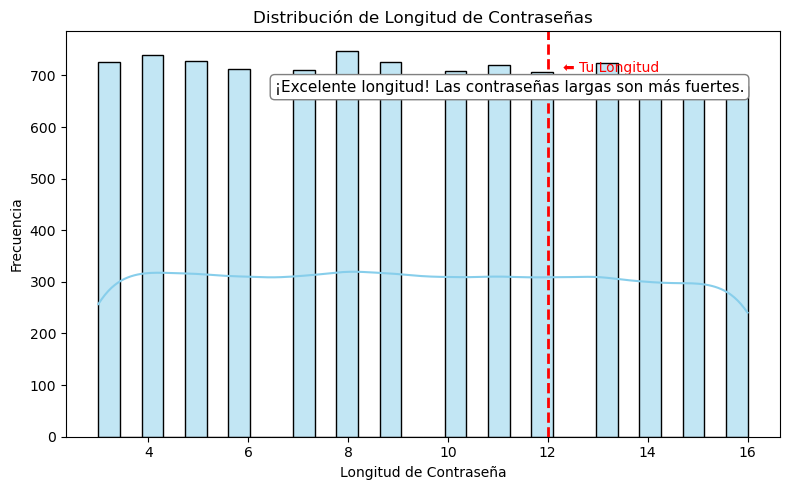

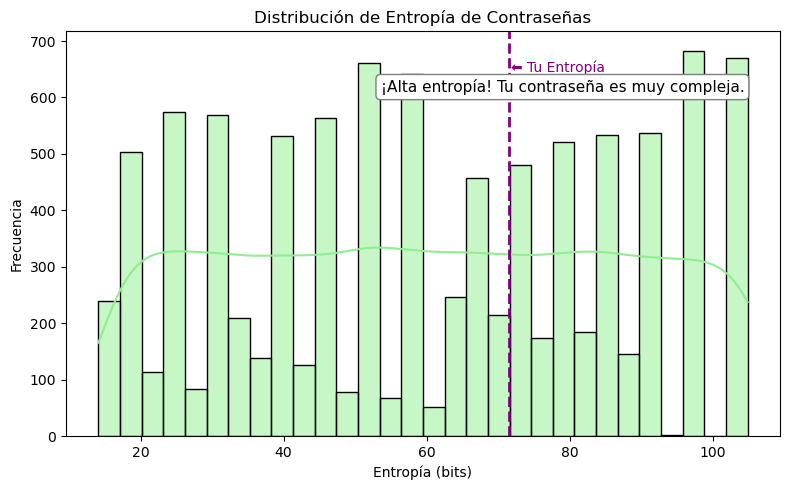

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir estadísticas de tu contraseña
longitud = len(contrasena_usuario)
valor_entropia = entropia_practica(contrasena_usuario)

# Calcular entropía para todas las contraseñas
df_todo["entropia"] = df_todo["Contraseña"].apply(entropia_practica)

# ---- GRÁFICO 1: Longitud de Contraseña ----
plt.figure(figsize=(8, 5))
sns.histplot(df_todo["Contraseña"].apply(len), bins=30, kde=True, color='skyblue')

# Flecha del usuario
plt.axvline(longitud, color='red', linestyle='--', linewidth=2)
plt.text(longitud + 0.3, plt.ylim()[1] * 0.9, "⬅️ Tu Longitud", color='red', fontsize=10)

# Texto explicativo
if longitud < 8:
    comentario = "Las contraseñas cortas son más fáciles de crackear."
elif longitud < 12:
    comentario = "Longitud decente, pero podría ser más larga."
else:
    comentario = "¡Excelente longitud! Las contraseñas largas son más fuertes."

plt.title("Distribución de Longitud de Contraseñas")
plt.xlabel("Longitud de Contraseña")
plt.ylabel("Frecuencia")
plt.text(0.95, 0.85, comentario, transform=plt.gca().transAxes, ha='right', fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray"))

plt.tight_layout()
plt.show()

# ---- GRÁFICO 2: Entropía de Contraseña ----
plt.figure(figsize=(8, 5))
sns.histplot(df_todo["entropia"], bins=30, kde=True, color='lightgreen')

# Flecha del usuario
plt.axvline(valor_entropia, color='purple', linestyle='--', linewidth=2)
plt.text(valor_entropia + 0.3, plt.ylim()[1] * 0.9, "⬅️ Tu Entropía", color='purple', fontsize=10)

# Texto explicativo
if valor_entropia < 30:
    comentario_ent = "Baja entropía = estructura predecible."
elif valor_entropia < 50:
    comentario_ent = "Entropía aceptable — bien, pero puede ser más fuerte."
else:
    comentario_ent = "¡Alta entropía! Tu contraseña es muy compleja."

plt.title("Distribución de Entropía de Contraseñas")
plt.xlabel("Entropía (bits)")
plt.ylabel("Frecuencia")
plt.text(0.95, 0.85, comentario_ent, transform=plt.gca().transAxes, ha='right', fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray"))

plt.tight_layout()
plt.show()
